# Monkeypox Classifier CNN

## Import Library

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import os, sys
import numpy as np
import plotly.express as px
import pandas as pd

## Dataset
Training data berasal dari augmented images
Validation data berasal dari Fold1/Validation
Testing data berasal Original Images, yaitu gambar original dari cacar monyet

In [31]:
train = "Augmented Images"
val = "Fold1/Val"
test = "Original Images"

classes = ["Monkeypox", "Others"]

## Import dataset using keras

In [32]:
IMG_SIZE = (180, 180)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train,image_size=IMG_SIZE ,label_mode="binary", batch_size=32,shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test, image_size=IMG_SIZE, label_mode="binary", batch_size=32, shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val, image_size=IMG_SIZE, label_mode="binary", batch_size=32,shuffle=True)

Found 3193 files belonging to 2 classes.
Found 228 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


# Data Info

In [33]:
trainingInfo = pd.read_csv('infofile/Info Training.csv')
validationInfo = pd.read_csv('infofile/Info Validation.csv')
testingInfo = pd.read_csv('infofile/Info Testing.csv')

In [34]:
def classDistribution(df, title):
    fig = px.pie(
        names=df.Labels.unique(),
        values=df.Labels.value_counts(),
        hole=0.2,
        width=500,
        height=500
    )
    fig.update_layout({'title':{'text':title+' Class Distribution','x':0.45}})
    return fig

In [35]:
classDistribution(trainingInfo, "Training")

In [36]:
classDistribution(validationInfo, "validation")

In [37]:
classDistribution(testingInfo, "Testing")

In [38]:
def visualize_random_images(dataset_type, label_type):
    sample = 9
    plt.figure(figsize=(15, 8))
    type_dir = train if dataset_type=="train" else test
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

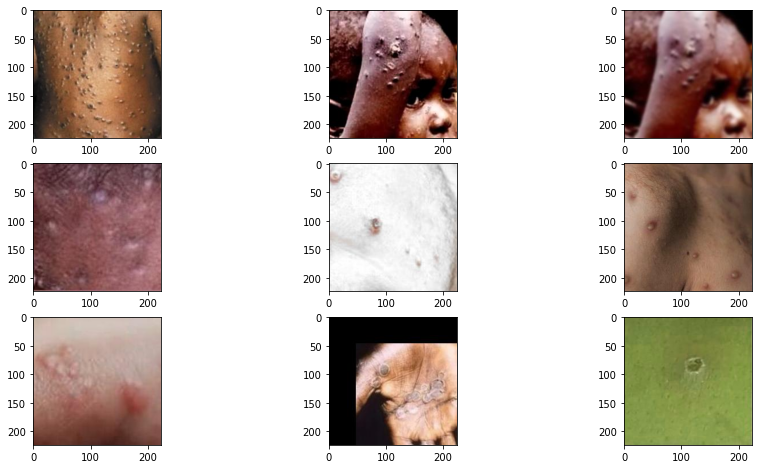

In [39]:
visualize_random_images("train", "Monkey pox")

In [40]:
def plot_loss_curves(history):
    
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Models
Saya tidak mencoba pre-trained model karena komputasi yang cukup kompleks dan waktu yang lebih lama.
Saya membangun neural network sendiri seperti pada cell dibawah ini


In [41]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(64, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5)

In [15]:
history = model.fit(train_data, validation_data=val_data, epochs=35, callbacks=cb)

Epoch 1/35
100/100 [==============================] - 50s 492ms/step - loss: 0.7445 - accuracy: 0.5427 - val_loss: 0.6820 - val_accuracy: 0.6000
Epoch 2/35
100/100 [==============================] - 48s 473ms/step - loss: 0.6876 - accuracy: 0.5531 - val_loss: 0.6755 - val_accuracy: 0.6000
Epoch 3/35
100/100 [==============================] - 47s 471ms/step - loss: 0.6881 - accuracy: 0.5521 - val_loss: 0.6752 - val_accuracy: 0.6000
Epoch 4/35
100/100 [==============================] - 48s 475ms/step - loss: 0.6879 - accuracy: 0.5575 - val_loss: 0.6741 - val_accuracy: 0.6000
Epoch 5/35
100/100 [==============================] - 48s 475ms/step - loss: 0.6834 - accuracy: 0.5609 - val_loss: 0.6587 - val_accuracy: 0.6071
Epoch 6/35
100/100 [==============================] - 48s 482ms/step - loss: 0.6879 - accuracy: 0.5606 - val_loss: 0.6553 - val_accuracy: 0.6786
Epoch 7/35
100/100 [==============================] - 48s 475ms/step - loss: 0.6808 - accuracy: 0.5844 - val_loss: 0.6242 - val_ac

## Learning Curves

In [16]:
plot_loss_curves(history)

In [17]:
model.evaluate(test_data)

8/8 [==============================] - 1s 128ms/step - loss: 0.0153 - accuracy: 1.0000


[0.015252076089382172, 1.0]

In [18]:
y_pred = [ np.argmax(i) for i in model.predict(test_data)]

In [19]:
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [20]:
accuracy_score(y_true, y_pred)

1.0

In [21]:
print(classification_report(y_true, y_pred, target_names=val_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       1.00      1.00      1.00       102
      Others       1.00      1.00      1.00       126

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228



In [22]:
cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)

Text(69.0, 0.5, 'Truth')

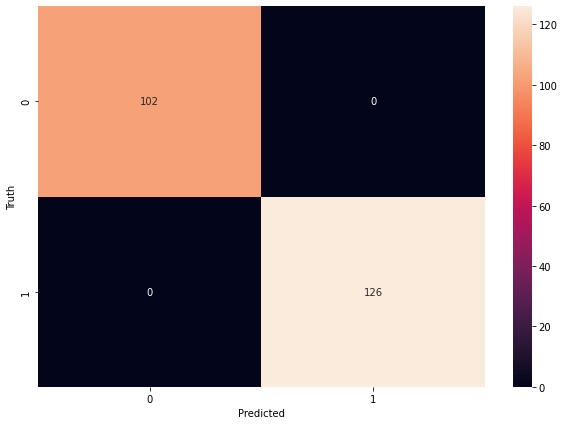

In [23]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Testing Model using single image

In [24]:
def tampilFoto(img, label):
    plt.figure(figsize=(20,20))
    plt.xlabel(label)
    plt.imshow(img, cmap='gray')
        
        

In [25]:
#Test to predict single image
def predictImage(path):
    image  = tf.keras.preprocessing.image.load_img(path, target_size=IMG_SIZE)
    single_img = tf.keras.preprocessing.image.img_to_array(image)
    single_img = np.expand_dims(single_img, axis = 0)
    predict = classes [np.argmax(model.predict((single_img)))]
    plt.xlabel(predict)
    plt.imshow(image)
    


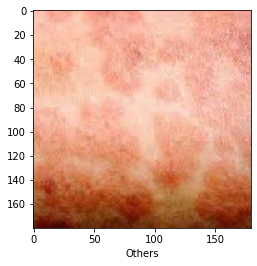

In [26]:
predictImage("Fold1/Test/Others/NM02_01.jpg")

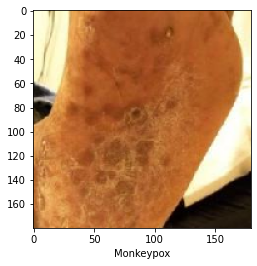

In [27]:
predictImage("Original Images\Monkey Pox\M05_01.jpg")

In [28]:
predictImage("Fold1/Val/Others/NM75_01_05.jpg")

In [29]:
predictImage("cacarair.jpg")